# Spring 2024 - CSE-6040 | Extra Credit Project

**Assignment Due:** Thursday, Apr 25th @ 1159 UTC

**Peer-grading Due:** Wednesday, May 1st @ 1159 UTC

*Author: Ryan Hopkins*

***Table of Contents:***
- [Topic and Motivation](#topic-and-motivation)
- [Data](#data)
    - [Data Structure](#data-structure)
    - [Hypotheses and Models](#hypotheses-and-models)
- [Data Preprocessing](#data-preprocessing)
    - [Relevant Packages](#relevant-packages)
    - [Merge Datasets](#merge-datasets)
    - [Imputation](#imputation)
        - [Basic Imputes](#basic-imputes)
        - [Regression Imputes](#regression-imputes)
            - [`imdb_score` Impute](#imdb_score-impute)
            - [`tmdb_popularity` Impute](#tmdb_popularity-impute)
        - [Logarithmic Impute](#logarithmic-impute)
            - [`age_rating` Impute](#age_rating-impute)
- [Analysis](#analysis)
    - [Hypotheses](#hypotheses)
        - [Critically Acclaimed](#critically-acclaimed)
        - [Popularity](#popularity)
        - [Kid Friendly](#kid-friendly)
        - [Diversity](#diversity)
    - [Model](#model)
        - [Feature Engineering](#feature-engineering)
            - [K-means](#k-means)
            - [PCA](#pca)
        - [Training](#training)
        - [Recommendations](#recommendations)
- [Overview](#overview)


## Topic and Motivation
The topic I have chosen for this project relates to one of my favorite hobbies: **Cinema**. I cherish and consider cinema to be an art form that transcends simple popcorn entertainment. Of course, a lot of movies are made just to be shallow and fun, which I like, but I primarily love watching a movie and appreciating the unique production design, directorial decisions, acting performances, score, lighting, writing, etc.

**There are two problems every cinephile encounters:**
1. There are way too many subscription-based streaming services!
2. The never-ending search for other good movies. (Despite having 200 in my watchlist)

In order to alleviate these concerns, I searched for datasets relating to streaming services and their respective movie databases, outlined below.

## Data
I primarily used [Kaggle](https://www.kaggle.com/) to find my streaming datasets. I will hyperlink each dataset for documentation purposes and in the case anyone is interested in delving further into the project.

As (hopefully) seen in the Vocareum directory, I found datasets for the following streaming services:
- [Amazon Prime Video](https://www.kaggle.com/datasets/victorsoeiro/amazon-prime-tv-shows-and-movies?select=titles.csv)
- [AppleTV+](https://www.kaggle.com/datasets/dgoenrique/apple-tv-movies-and-tv-shows?select=titles.csv)
- [Disney+](https://www.kaggle.com/datasets/victorsoeiro/disney-tv-shows-and-movies?select=titles.csv)
- [HBO Max](https://www.kaggle.com/datasets/dgoenrique/hbo-max-movies-and-tv-shows?select=titles.csv)
- [Netflix](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv)
- [Paramount+](https://www.kaggle.com/datasets/victorsoeiro/paramount-tv-shows-and-movies?select=titles.csv)

### Data Structure
I got lucky and found datasets with congruent data structures, even though they were primarily sourced by three different curators! The only discrepancy between them is the date each dataset was curated, which affects some of the movie data greatly. This will be handled in the cleaning of the data.

***Content***

These datasets contain two files, one for the titles (`titles.csv`) and the other for the cast (`credits.csv`) of each movie and show on the platform.

The `titles.csv` contains more than 3k titles, witch 15 columns containing:

- `id`: The title ID on JustWatch.
- `title`: The name of the title.
- `type`: TV show or movie.
- `description`: A brief description.
- `release_year`: The release year.
- `age_certification`: The age certification.
- `runtime`: The length of the episode (SHOW) or movie.
- `genres`: A list of genres.
- `production_countries`: A list of countries that - produced the title.
- `seasons`: Number of seasons if it's a SHOW.
- `imdb_id`: The title ID on IMDB.
- `imdb_score`: Score on IMDB.
- `imdb_votes`: Votes on IMDB.
- `tmdb_popularity`: Popularity on TMDB.
- `tmdb_score`: Score on TMDB.

The `credits.csv` contains over 64k credits of actors and directors, with 5 columns containing:

- `person_ID`: The person ID on JustWatch.
- `id`: The title ID on JustWatch.
- `name`: The actor or director's name.
- `character_name`: The character name.
- `role`: ACTOR or DIRECTOR.

<br>

For this project, I only utilized the `titles.csv` file from each dataset for two reasons:
1. Including both files for each streaming database would exceed the maximum data limit for the project (10MB).
2. I prioritized the variety of streaming services in order to have the largest pool of movies possible.


### Hypotheses and Models
From these datasets, I hope to alleviate the two problems every cinephile encounters, as restated below:

<br>

***There are way too many subscription-based streaming services!***

We're not made of money, so we can ask some questions that might help narrow down our choices depending on what each of us prioritize in a streaming service.
- **Hypothesis**: Which streaming platform has more critically acclaimed movies?
  - **Prediction**: *HBO Max*
- **Hypothesis**: Which streaming platform has more popular movies?
  - **Prediction**: *Netflix*
- **Hypothesis**: Which streaming platform has more kid friendly movies?
  - **Prediction**: *Disney+*
- **Hypothesis**: Which streaming platform has more genre diversity?
  - **Prediction**: *Amazon*

<br>

***The never-ending search for other good movies.***

It takes way too long to read reddit post, after reddit post, after reddit post on movie recommendations you've most likely already seen. So, we'll create a platform-filtered recommendation system based on these movie databases. 
- **Recommendation Model**: Create a recommendation system using `KNN` on movie features.
  - Use `regex` to create a fuzzy movie search feature.
  - Use `kmeans` and `PCA` to feature engineer categorical data, like `genres`.

## Data Preprocessing

### Relevant Packages

In [116]:
# Load Packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
import ast

### Merge Datasets

First, let's read in the datasets and get a good look at them:

In [213]:
# Read in CSV as Data Frames
Amazon_df = pd.read_csv('/Documents/GT/CSE 6040/AmazonPrimeTV.csv')
AppleTV_df = pd.read_csv('/Documents/GT/CSE 6040/AppleTVPlus.csv')
DisneyPlus_df = pd.read_csv('/Documents/GT/CSE 6040/DisneyPlus.csv')
HBOMax_df = pd.read_csv('/Documents/GT/CSE 6040/Max.csv')
Netflix_df = pd.read_csv('/Documents/GT/CSE 6040/Netflix.csv')
ParamountTV_df = pd.read_csv('/Documents/GT/CSE 6040/ParamountTV.csv')

# Display the first few rows of each DataFrame to inspect their structure
dfs = {
    "Amazon Prime": Amazon_df.head(5),
    "Apple TV Plus": AppleTV_df.head(5),
    "Disney Plus": DisneyPlus_df.head(5),
    "HBO Max": HBOMax_df.head(5),
    "Netflix": Netflix_df.head(5),
    "Paramount": ParamountTV_df.head(5)
}
dfs

{'Amazon Prime':         id                        title   type  \
 0  ts20945            The Three Stooges   SHOW   
 1  tm19248                  The General  MOVIE   
 2  tm82253  The Best Years of Our Lives  MOVIE   
 3  tm83884              His Girl Friday  MOVIE   
 4  tm56584            In a Lonely Place  MOVIE   
 
                                          description  release_year  \
 0  The Three Stooges were an American vaudeville ...          1934   
 1  During America’s Civil War, Union spies steal ...          1926   
 2  It's the hope that sustains the spirit of ever...          1946   
 3  Hildy, the journalist former wife of newspaper...          1940   
 4  An aspiring actress begins to suspect that her...          1950   
 
   age_certification  runtime  \
 0             TV-PG       19   
 1               NaN       78   
 2               NaN      171   
 3               NaN       92   
 4               NaN       94   
 
                                               g

Hmmm, there's a lot of data here. Considering we'll have to merge these datasets, and considering the datasets were curated months apart from each other, there are some columns that are more of a headache than they're worth to me. 

So, we'll get rid of some of the categorical features that change easily over time (`seasons`, `imdb_votes`), are redundant to other columns (`tmdb_score`, `imdb_id`), and are too difficult to get insight out of without using more advanced methods (`description`).

In [118]:
# Remove most qualitative data to reduce errors when merging
df_list = [Amazon_df, AppleTV_df, DisneyPlus_df, HBOMax_df, Netflix_df, ParamountTV_df]
col_to_drop = ['description','seasons','tmdb_score', 'imdb_votes', 'imdb_id']

Amazon_df = Amazon_df.drop(columns = col_to_drop)
AppleTV_df = AppleTV_df.drop(columns = col_to_drop)
DisneyPlus_df = DisneyPlus_df.drop(columns = col_to_drop)
HBOMax_df = HBOMax_df.drop(columns = col_to_drop)
Netflix_df = Netflix_df.drop(columns = col_to_drop)
ParamountTV_df = ParamountTV_df.drop(columns = col_to_drop)

# Display the remaining columns
print(Amazon_df.columns.to_list())

['id', 'title', 'type', 'release_year', 'age_certification', 'runtime', 'genres', 'production_countries', 'imdb_score', 'tmdb_popularity']


Now that we have the structure we want, we can merge the datasets using the `outer join` method using the `id` of each movie as a key. We'll add a binary variable that indicates which streaming platform each movie is available on.

In [119]:
# Add a binary column to each DataFrame indicating platform availability
Amazon_df['on_amazon'] = 1
AppleTV_df['on_apple'] = 1
DisneyPlus_df['on_disney'] = 1
HBOMax_df['on_hbo'] = 1
Netflix_df['on_netflix'] = 1
ParamountTV_df['on_paramount'] = 1

# Initialize merged DataFrame with the first DataFrame to set the structure
merged_df = Amazon_df.copy()

# List of dataframes for iterative merging
merge_list = [AppleTV_df, DisneyPlus_df, HBOMax_df, Netflix_df, ParamountTV_df]
merge_cols = ['id', 'title', 'type', 'release_year', 'age_certification', 'runtime', 'genres', 'production_countries', 'imdb_score', 'tmdb_popularity']

# Merge each dataframe iteratively on 'id' column
for df in merge_list:
    merged_df = pd.merge(merged_df, df, on=merge_cols, how='outer', suffixes=('', '_dup'))

merged_df.head(5)

merged_df.to_csv('/Documents/GT/CSE 6040/Movies_merged.csv', index=False)

When using `outer join`, you have to watch out for rows with similar, but not exact, data creating "duplicate" rows. Let's search to see how many we have.

In [120]:
# Check for duplicate rows based on 'id'
duplicate_ids = merged_df.duplicated(subset='id', keep=False)
duplicates_df = merged_df[duplicate_ids]

# Display the DataFrame with potential duplicates
duplicates_df.head(6)

,id,title,type,release_year,age_certification,runtime,genres,production_countries,imdb_score,tmdb_popularity,on_amazon,on_apple,on_disney,on_hbo,on_netflix,on_paramount
26,tm1000619,Radhe Shyam,MOVIE,2022,NaN,138,"['drama', 'romance']",['IN'],5.3,5.537,NaN,NaN,NaN,NaN,1.0,NaN
27,tm1000619,Radhe Shyam,MOVIE,2022,NaN,138,"['romance', 'drama']",['IN'],6.9,9.770,1.0,NaN,NaN,NaN,NaN,NaN
148,tm101406,Aparajito,MOVIE,1956,NaN,110,['drama'],['IN'],8.3,6.255,NaN,NaN,NaN,1.0,NaN,NaN
149,tm101406,Aparajito,MOVIE,1956,NaN,110,['drama'],['IN'],8.3,8.416,1.0,NaN,NaN,NaN,NaN,NaN
217,tm101914,The Fighter,MOVIE,2010,R,114,['drama'],['US'],NaN,14.111,1.0,NaN,NaN,NaN,NaN,1.0
218,tm101914,The Fighter,MOVIE,2010,R,115,['drama'],['US'],NaN,17.007,NaN,NaN,NaN,NaN,1.0,NaN


As stated above, the discrepancies most likely originate from data curation timelines. Thus, we can assume quantitative metrics, like `imdb_score` and `tmdb_popularity`, comprise the bulk of the discrepancies.

Hence, we will now group the rows using the following rules:
- Keep the categorical data constant
- Use the mean of the quantitative data
- Conserve the platform binary data

In [121]:
# Define a function to return 1 if any value is 1, otherwise NaN
def max_or_nan(series: int) -> int:
    return 1 if series.max() == 1 else np.nan

# Filter the duplicates
merged_df = (
    merged_df
    .groupby('id', as_index=False)
    .agg({
        'title': 'first',  # Keep the first title
        'type': 'first',  # Keep the first type
        'release_year': 'first',  # Keep the first release year
        'age_certification': 'first',  # Keep the first age certification
        'runtime': 'first',  # Keep the first runtime
        'genres': 'first',  # Keep the first genres
        'production_countries': 'first',  # Keep the first production countries
        'imdb_score': 'mean',  # Average the scores
        'tmdb_popularity': 'mean',  # Average the popularity
        'on_amazon': max_or_nan,
        'on_apple': max_or_nan,
        'on_disney': max_or_nan,
        'on_hbo': max_or_nan,
        'on_netflix': max_or_nan,
        'on_paramount': max_or_nan
    })
)

# Check if grouping worked
duplicate_ids = merged_df.duplicated(subset='id', keep=False)
duplicates_df = merged_df[duplicate_ids]
display(duplicates_df)

,id,title,type,release_year,age_certification,runtime,genres,production_countries,imdb_score,tmdb_popularity,on_amazon,on_apple,on_disney,on_hbo,on_netflix,on_paramount


Looks like it worked! Now let's move onto imputing the missing data.

In [122]:
# Convert the string representation of lists to actual lists
merged_df['genres'] = merged_df['genres'].apply(ast.literal_eval)

# Extract unique genres
unique_genres = set()
for genres in merged_df['genres']:
    unique_genres.update(genres)

# Sort genres to maintain consistency
unique_genres = sorted(unique_genres)

# Create a binary column for each genre
for genre in unique_genres:
    merged_df[f'{genre}'] = merged_df['genres'].apply(lambda x: int(genre in x))

In [123]:
# Now merged_df has a new binary column for each genre
unique_genres

['action',
 'animation',
 'comedy',
 'crime',
 'documentation',
 'drama',
 'european',
 'family',
 'fantasy',
 'history',
 'horror',
 'music',
 'reality',
 'romance',
 'scifi',
 'sport',
 'thriller',
 'war',
 'western']

In [124]:
print(merged_df.head(5))

          id                        title   type  release_year  \
0        tm1                    Star Wars  MOVIE          1977   
1       tm10                   The Matrix  MOVIE          1999   
2    tm10000                    Jury Duty  MOVIE          1995   
3   tm100001              The Lucky Texan  MOVIE          1934   
4  tm1000022  Boonie Bears: The Wild Life  MOVIE          2021   

  age_certification  runtime                      genres production_countries  \
0                PG      125    [scifi, action, fantasy]               ['US']   
1                 R      136             [action, scifi]               ['US']   
2             PG-13       88             [comedy, drama]               ['US']   
3              None       61  [western, action, romance]               ['US']   
4              None       99          [scifi, animation]               ['CN']   

   imdb_score  tmdb_popularity  ...  history  horror  music  reality  romance  \
0         8.6           77.321  ...

### Imputation

#### Basic Imputes

Let's see which features we need to impute.

In [125]:
# Check for NaN values across all columns
nan_counts = merged_df.isna().sum()
print(nan_counts)

id                          0
title                       1
type                        0
release_year                0
age_certification       10942
runtime                     0
genres                      0
production_countries        0
imdb_score               2391
tmdb_popularity           717
on_amazon               11474
on_apple                21172
on_disney               19807
on_hbo                  18312
on_netflix              15492
on_paramount            18517
action                      0
animation                   0
comedy                      0
crime                       0
documentation               0
drama                       0
european                    0
family                      0
fantasy                     0
history                     0
horror                      0
music                       0
reality                     0
romance                     0
scifi                       0
sport                       0
thriller                    0
war       

As you can see, the `on_{platform}` columns have `NaN` values for movies not found in the respective platform dataset. Let's impute these values with their logical binary equivalent, `0`.

In [126]:
# Fill NaN values with 0
platform_columns = ['on_amazon', 'on_apple', 'on_disney', 'on_hbo', 'on_netflix', 'on_paramount']
merged_df[platform_columns] = merged_df[platform_columns].fillna(0).astype(int)
merged_df.head(5)

,id,title,type,release_year,age_certification,runtime,genres,production_countries,imdb_score,tmdb_popularity,...,history,horror,music,reality,romance,scifi,sport,thriller,war,western
0,tm1,Star Wars,MOVIE,1977,PG,125,"[scifi, action, fantasy]",['US'],8.6,77.321,...,0,0,0,0,0,1,0,0,0,0
1,tm10,The Matrix,MOVIE,1999,R,136,"[action, scifi]",['US'],8.7,76.460,...,0,0,0,0,0,1,0,0,0,0
2,tm10000,Jury Duty,MOVIE,1995,PG-13,88,"[comedy, drama]",['US'],4.2,8.846,...,0,0,0,0,0,0,0,0,0,0
3,tm100001,The Lucky Texan,MOVIE,1934,None,61,"[western, action, romance]",['US'],5.6,4.079,...,0,0,0,0,1,0,0,0,0,1
4,tm1000022,Boonie Bears: The Wild Life,MOVIE,2021,None,99,"[scifi, animation]",['CN'],5.4,6.135,...,0,0,0,0,0,1,0,0,0,0


Now, let's just get rid of that pesky `title` NaN value. We will just drop that `title`, since i can't think of a way to impute a `title` with the given data.

In [127]:
# Drop the NaN title row
title_nan = merged_df[merged_df['title'].isna()]
nan_index = title_nan.index.to_list()
merged_df = merged_df.drop(nan_index)

In [128]:
# Check for NaN values across all columns
nan_counts = merged_df.isna().sum()
print(merged_df.shape, "\n")
print(nan_counts)

(21341, 35) 

id                          0
title                       0
type                        0
release_year                0
age_certification       10941
runtime                     0
genres                      0
production_countries        0
imdb_score               2390
tmdb_popularity           716
on_amazon                   0
on_apple                    0
on_disney                   0
on_hbo                      0
on_netflix                  0
on_paramount                0
action                      0
animation                   0
comedy                      0
crime                       0
documentation               0
drama                       0
european                    0
family                      0
fantasy                     0
history                     0
horror                      0
music                       0
reality                     0
romance                     0
scifi                       0
sport                       0
thriller                  

We will handle the rest of the imputes using `Regression` and `Logistic` models!

#### Regression Imputes

##### `imdb_score` Impute

To impute using **Linear Regression**, we will split the data into **features** and a **target variable**.

In [129]:
# Ensure no NaN values in the target and features to train model
feature_list = unique_genres + ['release_year', 'runtime', 'tmdb_popularity', 'on_amazon', 'on_apple', 'on_disney', 'on_hbo', 'on_netflix', 'on_paramount']
clean_df = merged_df.dropna(subset= ['imdb_score', 'tmdb_popularity'] + feature_list)

# Select features
features = clean_df[feature_list]
target = clean_df['imdb_score']

**Linear Regression** assumes a roughly **normally distributed target variable**. We can use a histogram to visualize this:

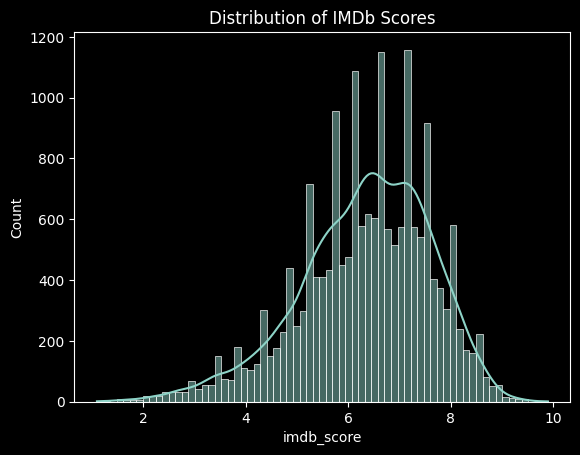

In [130]:
# Histogram of imdb scores
plt.style.use('dark_background')
sns.histplot(target, kde=True)
plt.title('Distribution of IMDb Scores')
plt.show()

> This looks pretty good! A little right skewed, but roughly normal to the eye. We can work with this.

Next, we split the data into **training** and **testing** subsets to later test the validitiy of the model.

In [131]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Then, we plot the residuals on a **Quantile-Quantile (Q-Q) plot**. The more linear the realtionship, the higher the plausibility the data can be mapped to a normal distribution.

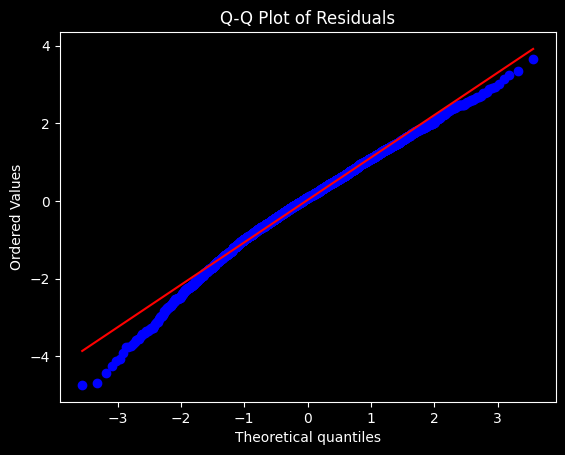

In [132]:
# Q-Q plot for residuals
residuals = y_test - y_pred
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

> The **Q-Q plot** looks acceptable. I applied log and polynomial transformations, but they made the distribution worse. So I left it as so.

Now we can calculate the performance metrics for the model we will use to impute the `imdb_scores`.

In [133]:
# Check performance metrics for imdb score regression model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 0.854597818609052
Mean Squared Error: 1.2046197817604223
Root Mean Squared Error: 1.0975517216789477
R-squared: 0.24655140972996592


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Performance of our regression model:

1. **MAE (Mean Absolute Error) of 0.855**: This indicates that, on average, our model's predictions are about 0.855 points away from the actual `imdb_score` values. Given the typical scale of IMDb scores (1 to 10), this error could be considered moderate.

2. **MSE (Mean Squared Error) of 1.205** and **RMSE (Root Mean Squared Error) of 1.098**: MSE and RMSE are both measures of the average squared magnitude of the error. This value indicates that there may be several instances where the predictions are significantly off. RMSE being around 1.098 suggests that the typical error is just over 1 point.

3. **R-squared of 0.247**: This is moderatley low, indicating that only about 24.7% of the variance in the `imdb_score` is being explained by our model. This suggests that the predictors currently used might not be capturing a lot of the information necessary to accurately predict `imdb_score`, or that the linear relationship assumed by the regression model does not hold well.

Before we can impute the data, we have to handle the `NaN` values in `tmdb_popularity`. Later, I will impute `tmdb_popularity` with a regression model, so we'll temporarily impute `tmdb_popularity` with its mean. Then, use this as an input to predict the `imdb_score` imputes.

In [134]:
# Create temporary dataframe and impute `tmdb_popularity` using the mean
temp_df = merged_df.copy()
tmdb_popularity_mean = temp_df['tmdb_popularity'].mean()
temp_df['tmdb_popularity'] = temp_df['tmdb_popularity'].fillna(tmdb_popularity_mean)

# Predict missing imdb_scores
imdb_score_predictions = model.predict(temp_df.loc[temp_df['imdb_score'].isna(), feature_list])
merged_df.loc[merged_df['imdb_score'].isna(), 'imdb_score'] = np.round(imdb_score_predictions,1)

In [135]:
# Check for NaN values across all columns
nan_counts = merged_df.isna().sum()
print(merged_df.shape, "\n")
print(nan_counts)

(21341, 35) 

id                          0
title                       0
type                        0
release_year                0
age_certification       10941
runtime                     0
genres                      0
production_countries        0
imdb_score                  0
tmdb_popularity           716
on_amazon                   0
on_apple                    0
on_disney                   0
on_hbo                      0
on_netflix                  0
on_paramount                0
action                      0
animation                   0
comedy                      0
crime                       0
documentation               0
drama                       0
european                    0
family                      0
fantasy                     0
history                     0
horror                      0
music                       0
reality                     0
romance                     0
scifi                       0
sport                       0
thriller                  

>For further improvements that are outside the scope of this project, consider:
>1. Using **non-linear regression** models for imputation (e.g. polynomial).
>2. Use **decision trees** for imputation.

##### `tmdb_popularity` Impute

This will seem like deja-vu, so I'll go quickly through it.

Define features and target.

In [136]:
# Ensure no NaN values in the target and predictors to train model
feature_list = unique_genres + ['release_year', 'runtime', 'imdb_score', 'on_amazon', 'on_apple', 'on_disney', 'on_hbo', 'on_netflix', 'on_paramount']
clean_df = merged_df.dropna(subset= ['tmdb_popularity'] + feature_list)

# Select features
features = clean_df[feature_list]
target = clean_df['tmdb_popularity']

Look for normailty.

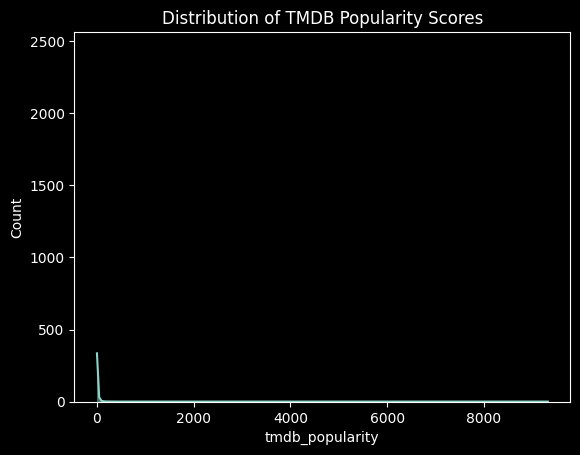

In [137]:
# Histogram of tmdb_popularity scores
plt.style.use('dark_background')
sns.histplot(target, kde=True)
plt.title('Distribution of TMDB Popularity Scores')
plt.show()

It's not normal, so let's use a log transform.

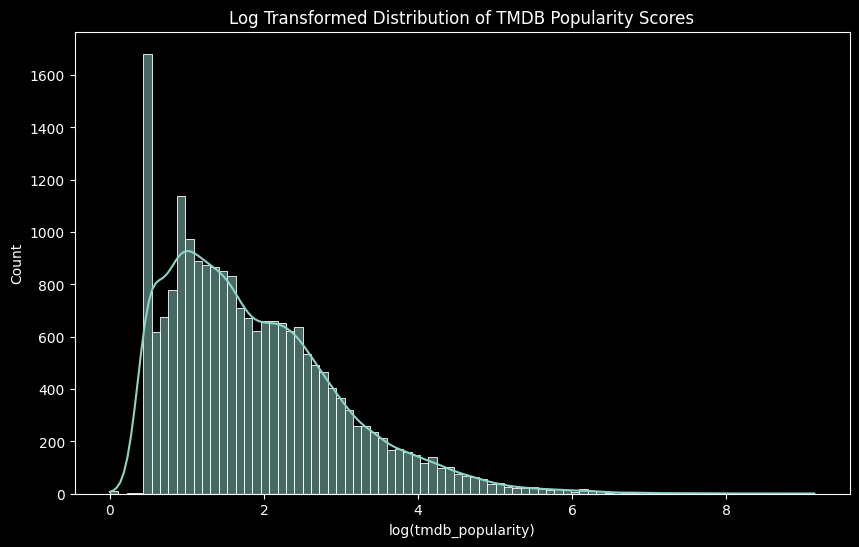

In [138]:
# Log transformation of tmdb_popularity scores
target_log = np.log1p(target)
plt.figure(figsize=(10, 6))
sns.histplot(target_log, kde=True)
plt.title('Log Transformed Distribution of TMDB Popularity Scores')
plt.xlabel('log(tmdb_popularity)')
plt.show()

> This looks a lot closer to normally distributed. Still very left-skewed, but acceptable for our purposes.

> Looking online, I found that `sklearn.preprocessing` has a `QuantileTransformer` that can transform  features to follow a uniform or a normal distribution. This would be better for our regression, but this falls outside the scope of this project.

Split into **train** and **test** subsets for validity.

In [139]:
# Splitting data into training and missing sets
X_train, X_test, y_train, y_test = train_test_split(features, target_log, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

**Q-Q plot** for model normality.

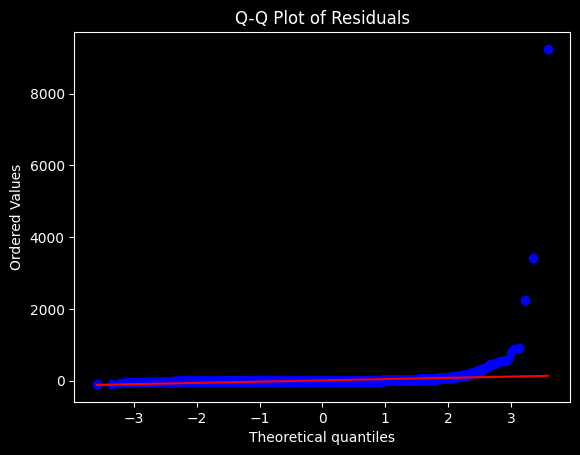

In [140]:
# Q-Q plot for residuals
y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

residuals = y_test - y_pred
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

> Not very inspiring. Looks linear for many of the datapoints, but there are some exponential outliers that ruin the normality of the relationship.

Let's look at the performance metrics to see if this impute is better than just using the median or mode.

In [141]:
# Check performance metrics for imdb score regression model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 15.523681838997602
Mean Squared Error: 26882.008177207543
Root Mean Squared Error: 163.95733645435797
R-squared: 0.016887558423248517


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Performance of our regression model:

1. **Mean Absolute Error (MAE)**: On average, the predictions of our model are about 15.52 units away from the true values. Which, considering the `tmdb_popularity` scores are continuous and unbounded, isn't relatively high.

2. **Mean Squared Error (MSE)**: The average of the squares of the errors is  26882.00. This is quite high, which suggests significant variance in the errors of the predictions. Since MSE is sensitive to outliers (due to squaring the errors), this high value could be influenced by the large outliers we noticed in the Q-Q plot.

3. **Root Mean Squared Error (RMSE)**: An RMSE of 163.96 means that the typical prediction error is 163.96 units. RMSE is more sensitive to outliers than MAE.

4. **R-squared (R²)**: The R² value is very close to zero, but it's positive, which is slightly better than just predicting the mean of the target for all observations. An R² score of 0 would indicate that the model explains none of the variability of the response data around its mean. Positive values of R² mean that the model is performing better than a horizontal line at the mean.

In summary, the  R² value indicates that the model is capturing almost none of the variance of the `tmdb_popularity` scores. The high values of MAE and RMSE suggest that the model's predictions are quite far off from the actual values, which can also imply that the model is not a good fit for this data. Thus, we will resort to a simpler imputation method.

Considering the extremely skewed distribution of the data, as shown above in the figure before we log transformed the data, we will impute using the median, rather than the mean, of `tmdb_popularity`, as the median is a better measure of central tendency for skewed data.

In [142]:
# Impute `tmdb_popularity` with the median
tmdb_popularity_median = merged_df['tmdb_popularity'].median()
print("Imputing `tmdb_popularity` with: ", tmdb_popularity_median)
merged_df['tmdb_popularity'] = merged_df['tmdb_popularity'].fillna(tmdb_popularity_median)

Imputing `tmdb_popularity` with:  4.216


In [143]:
# Check for NaN values across all columns
nan_counts = merged_df.isna().sum()
print(merged_df.shape, "\n")
print(nan_counts)

(21341, 35) 

id                          0
title                       0
type                        0
release_year                0
age_certification       10941
runtime                     0
genres                      0
production_countries        0
imdb_score                  0
tmdb_popularity             0
on_amazon                   0
on_apple                    0
on_disney                   0
on_hbo                      0
on_netflix                  0
on_paramount                0
action                      0
animation                   0
comedy                      0
crime                       0
documentation               0
drama                       0
european                    0
family                      0
fantasy                     0
history                     0
horror                      0
music                       0
reality                     0
romance                     0
scifi                       0
sport                       0
thriller                  

>For further improvements that are outside the scope of this project, consider:
>1. Using **Random Forests** or **Gradient Boosted Trees** for imputation.

#### Logarithmic Impute

##### `age_rating` Impute

To start, let's look at the distribution of `age_rating`.

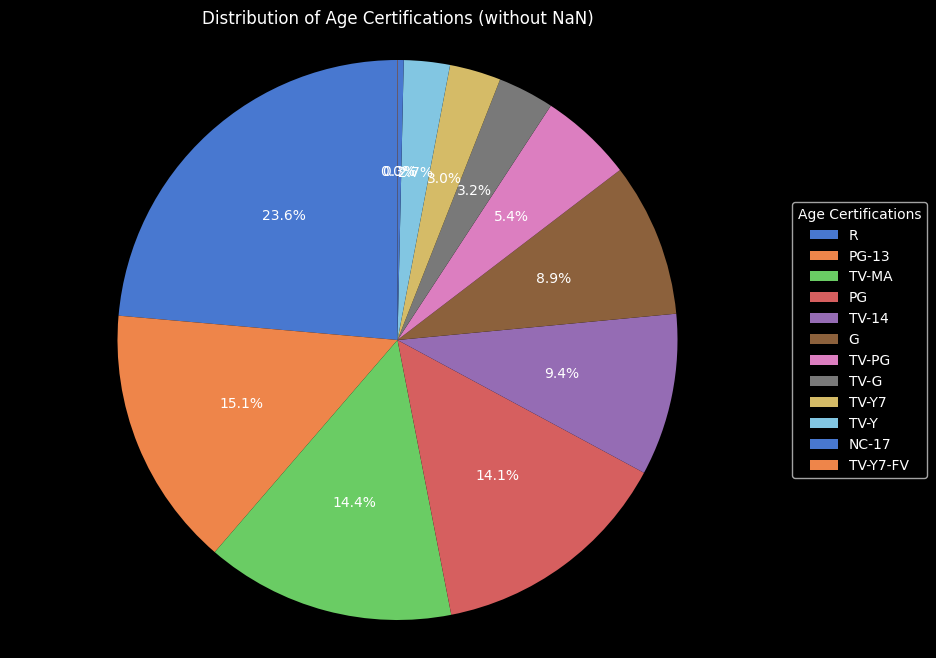

In [144]:
# Check age_certification distribution by using a pie chart
age_rating_counts = merged_df['age_certification'].dropna().value_counts()
plt.figure(figsize=(10, 8))
colors = sns.color_palette('muted', len(age_rating_counts))
plt.pie(age_rating_counts, labels=None, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Age Certifications (without NaN)')
plt.legend(age_rating_counts.index, title='Age Certifications', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

> The top 6 `age_rating` values have relatively equal shares of the distibutions. We'll reference this later.

Next, we **encode** the **categorical data** with **numeric labels**.

In [145]:
# Encode age_certification categories into numerical labels
encoder = LabelEncoder()
logistic_df = merged_df.copy()
mask = logistic_df['age_certification'].notna()  # Mask for rows where age_certification is not missing
logistic_df.loc[mask, 'age_certification_encoded'] = encoder.fit_transform(logistic_df.loc[mask, 'age_certification'])

# Define predictors
predictors = unique_genres + ['imdb_score', 'release_year', 'runtime', 'tmdb_popularity', 'on_amazon', 'on_apple', 'on_disney', 'on_hbo', 'on_netflix', 'on_paramount']
X = logistic_df[predictors]

# Scale the features using only the non-null age_certification rows
scaler = StandardScaler()
scaler.fit(X[mask])  # Fit scaler only on non-null rows
X_scaled = scaler.transform(X)  # Transform all rows

# Define the target variable using the non-null age_certification rows
y = logistic_df.loc[mask, 'age_certification_encoded']

Now, we split the data into `train` and `test` datasets. and train the model.

In [146]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled[mask], y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=3000)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

Then, let's calculate the performance metrics and see if we want to use this model to impute as opposed to another method.

In [147]:
# Calculate metrics
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=True)  # or 'micro', 'macro', 'weighted' based on your need
recall = recall_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy}\n")
print(f"Precision: {precision}\n")
print(f"Recall: {recall}\n")

Accuracy: 0.5134615384615384

Precision: 0.49871878902879374

Recall: 0.5134615384615384



1. **Accuracy**: Since we observed 6 roughly equally distributed classes, the random chance accuracy would be around 16.7%. The model's accuracy of 43.65% is significantly higher than this baseline.

2. **Precision and Recall**: Precision and recall provide insights into the model's performance on a per-class basis. Given the model's precision and recall are similar to its accuracy, it suggests some consistency in the model's ability to predict across different classes.

Since an accuracy of 51.35% is well above what would be expected by random guessing, especially considering there are multiple classes, this indicates that the model is a good choice over more basic imputation methods.

Let's look at the **confusion matrix** to see the **accuracy** and **precision** visualized. 

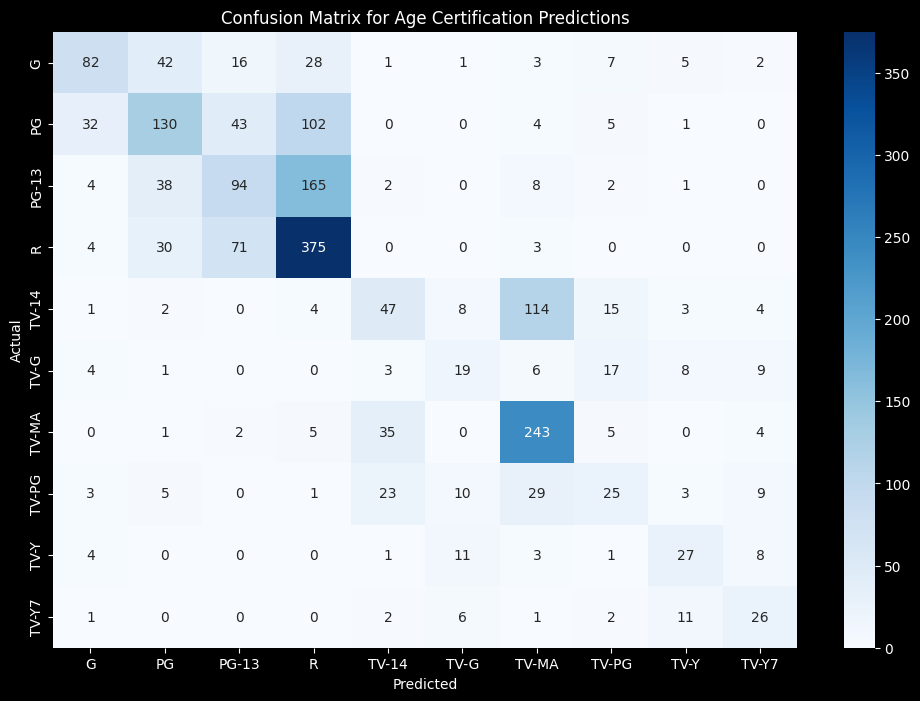

In [148]:
# Generate and plot the confusion matrix only for known data
cm_labels = np.unique(y_pred).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=cm_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.inverse_transform(cm_labels), yticklabels=encoder.inverse_transform(cm_labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Age Certification Predictions')
plt.show()

>It looks like `PG-13` and `TV-14` are the hardest to predict for our model. This may make sense since they share some features with the higher and lower ratings, thus making them hard to distinguish. 

Now, let's impute using the model.

In [149]:
# Predict age_certification for rows where it's missing
predicted_certifications = logistic_model.predict(X_scaled[~mask]).astype(int)
predicted_labels = encoder.inverse_transform(predicted_certifications)
merged_df.loc[~mask, 'age_certification'] = predicted_labels

In [150]:
# Check for NaN values across all columns
nan_counts = merged_df.isna().sum()
print(nan_counts)

id                      0
title                   0
type                    0
release_year            0
age_certification       0
runtime                 0
genres                  0
production_countries    0
imdb_score              0
tmdb_popularity         0
on_amazon               0
on_apple                0
on_disney               0
on_hbo                  0
on_netflix              0
on_paramount            0
action                  0
animation               0
comedy                  0
crime                   0
documentation           0
drama                   0
european                0
family                  0
fantasy                 0
history                 0
horror                  0
music                   0
reality                 0
romance                 0
scifi                   0
sport                   0
thriller                0
war                     0
western                 0
dtype: int64


## Analysis

Now that we've gone through all that cleaning and imputing, analysis should be pretty easy. Lets first start with the hypotheses, then move into the recommendation model.

***Recall:***

- **Hypothesis**: Which streaming platform has more critically acclaimed movies/shows?
  - **Prediction**: *HBO Max*
- **Hypothesis**: Which streaming platform has more popular movies/shows?
  - **Prediction**: *Netflix*
- **Hypothesis**: Which streaming platform has more kid friendly movies/shows?
  - **Prediction**: *Disney+*
- **Hypothesis**: Which streaming platform has more diversity?
  - **Prediction**: *Amazon*
- **Model**: Create a recommnedation system using `KNN` on movie features.
  - Use `regex` to create a fuzzy movie search feature.
  - Use `kmeans` and `PCA` to feature engineer categorical data, like `genres`.

In [214]:
# Visualize the cleaned merged_df
print(merged_df.head(10))

          id                        title   type  release_year  \
0        tm1                    Star Wars  MOVIE          1977   
1       tm10                   The Matrix  MOVIE          1999   
2    tm10000                    Jury Duty  MOVIE          1995   
3   tm100001              The Lucky Texan  MOVIE          1934   
4  tm1000022  Boonie Bears: The Wild Life  MOVIE          2021   
5  tm1000037                 Je suis Karl  MOVIE          2021   
6   tm100005                    Airplane!  MOVIE          1980   
7   tm100013    The Search for Santa Paws  MOVIE          2010   
8  tm1000147                     Zone 414  MOVIE          2021   
9   tm100015                       Takers  MOVIE          2010   

  age_certification  runtime                                genres  \
0                PG      125              [scifi, action, fantasy]   
1                 R      136                       [action, scifi]   
2             PG-13       88                       [comedy, dra

### Hypotheses

Let's start by looking at the prices of these streaming platforms without ads (as of April, 2024):

|Platform | Price/Month |
|---|---|
|AppleTV| $9.99|
|Amazon Video| $11.98|
|Paramount+| $11.99|
|Disney+| $13.99|
|Netflix| $15.49|
|HBO Max| $15.99|

In [152]:
# Initialize the prices
prices = {'Apple': 9.99,
          'Amazon': 11.98, 
          'Paramount': 11.99,
          'Disney': 13.99,
          'Netflix': 15.49,
          'Max': 15.99}

#### Critically Acclaimed

**Hypothesis**: Which streaming platform has more critically acclaimed movies?
  - **Prediction**: *HBO Max*

We'll count all the `imdb_score` values above a threshold and then plot them for each platform.

In [153]:
# Define a threshold for critically acclaimed movies
critically_acclaimed_threshold = 7.0

# Filter the DataFrame for critically acclaimed movies
critically_acclaimed_df = merged_df[merged_df['imdb_score'] >= critically_acclaimed_threshold]

# Count the number of critically acclaimed movies on each platform
acclaimed_counts = {
    'Amazon': critically_acclaimed_df['on_amazon'].sum(),
    'Apple': critically_acclaimed_df['on_apple'].sum(),
    'Disney': critically_acclaimed_df['on_disney'].sum(),
    'Max': critically_acclaimed_df['on_hbo'].sum(),
    'Netflix': critically_acclaimed_df['on_netflix'].sum(),
    'Paramount': critically_acclaimed_df['on_paramount'].sum(),
}

# Sorting the acclaimed_counts dictionary by values and reversing it to get from most to least
sorted_acclaimed_counts = dict(sorted(acclaimed_counts.items(), key=lambda item: item[1], reverse=True))

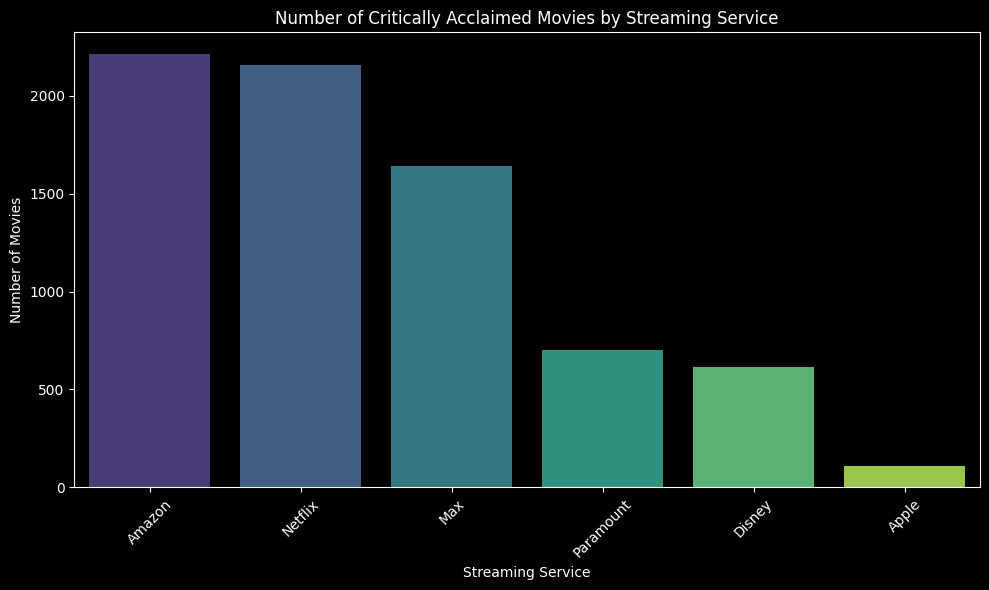

In [154]:
# Prepare the data for visualization
platforms, counts = zip(*sorted_acclaimed_counts.items())

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=platforms, y=counts, palette='viridis', hue=platforms, legend=False)
plt.title('Number of Critically Acclaimed Movies by Streaming Service')
plt.ylabel('Number of Movies')
plt.xlabel('Streaming Service')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Amazon** has the most critically acclaimed movies in their database, closely followed by **Netflix**. 

Which of these would be the best bang-for-buck?

In [155]:
# Calculate dollars per critically acclaimed movie
dollars_per_acclaimed = {
    platform: (np.round(prices[platform] / acclaimed_counts[platform], 4)) for platform in prices.keys() if acclaimed_counts[platform] 
}

# Sort dictionary by values in ascending order
sorted_dict = dict(sorted(dollars_per_acclaimed.items(), key=lambda item: item[1]))
print(sorted_dict)


{'Amazon': 0.0054, 'Netflix': 0.0072, 'Max': 0.0097, 'Paramount': 0.0172, 'Disney': 0.0228, 'Apple': 0.09}


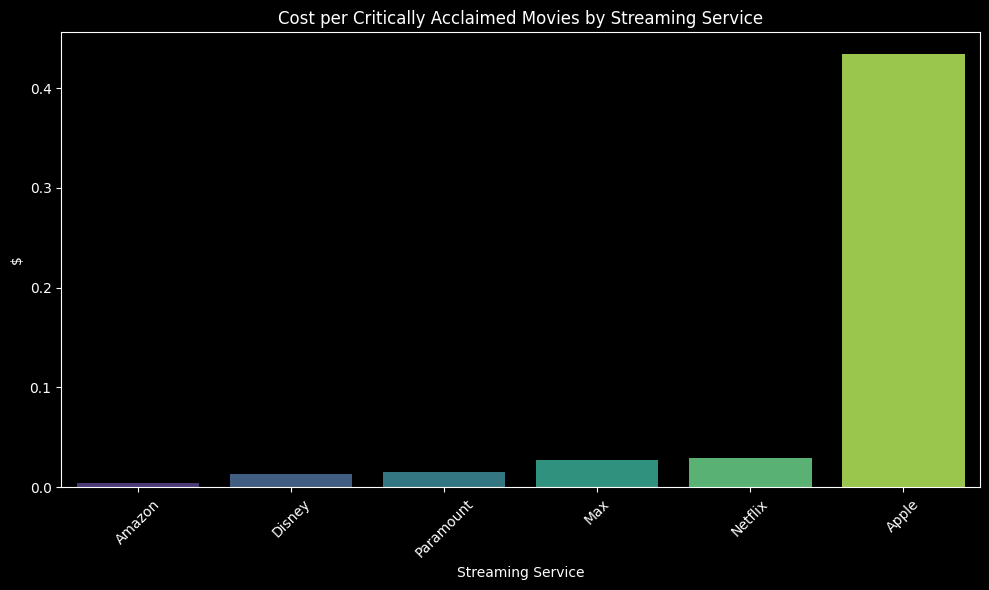

In [219]:
# Prepare the data for visualization
platforms, price = zip(*sorted_dict.items())

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=platforms, y=price, palette='viridis', hue=platforms, legend=False)
plt.title('Cost per Critically Acclaimed Movies by Streaming Service')
plt.ylabel('$')
plt.xlabel('Streaming Service')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The standings are the same!

If you prioritze critically acclaimed movies, then **Amazon** and **Netflix** are the are the best values, at **$0.0054/movie** and **$0.0072/movie** respectfully.

#### Popularity

We can define a movie to be popular when the `tmdb_popularity` **> 100**. This is honestly completely arbitrary since anything above 20 has a constant distribution with relation to these scores, so I just chose 100.

In [215]:
# Define a threshold for popular movies
popularity_threshold = 200

# Filter the DataFrame for popular movies
popularity_df = merged_df[merged_df['tmdb_popularity'] >= popularity_threshold]

# Count the number of popular movies on each platform
popularity_counts = {
    'Amazon': popularity_df['on_amazon'].sum(),
    'Apple': popularity_df['on_apple'].sum(),
    'Disney': popularity_df['on_disney'].sum(),
    'Max': popularity_df['on_hbo'].sum(),
    'Netflix': popularity_df['on_netflix'].sum(),
    'Paramount': popularity_df['on_paramount'].sum(),
}

# Sorting the popularity_counts dictionary by values and reversing it to get from most to least
sorted_popularity_counts = dict(sorted(popularity_counts.items(), key=lambda item: item[1], reverse=True))

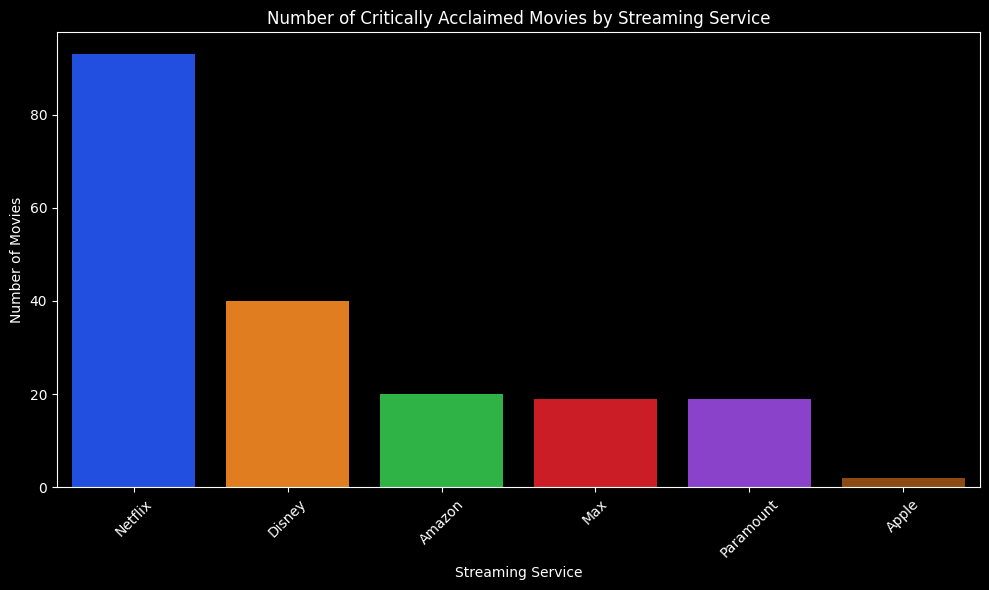

In [216]:
# Prepare the data for visualization
platforms, counts = zip(*sorted_popularity_counts.items())

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=platforms, y=counts, palette='bright', hue=platforms, legend=False)
plt.title('Number of Critically Acclaimed Movies by Streaming Service')
plt.ylabel('Number of Movies')
plt.xlabel('Streaming Service')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Netflix` has more popular movies and shows by far! It's no coincidence `Netflix` has been a household name for years.

In [159]:
# Calculate dollars per critically acclaimed movie
dollars_per_popularity = {
    platform: (np.round(prices[platform] / popularity_counts[platform], 4)) for platform in prices.keys() if popularity_counts[platform] 
}

# Sort dictionary by values in ascending order
sorted_dict = dict(sorted(dollars_per_popularity.items(), key=lambda item: item[1]))
print(sorted_dict)


{'Netflix': 0.1666, 'Disney': 0.3498, 'Amazon': 0.599, 'Paramount': 0.6311, 'Max': 0.8416, 'Apple': 4.995}


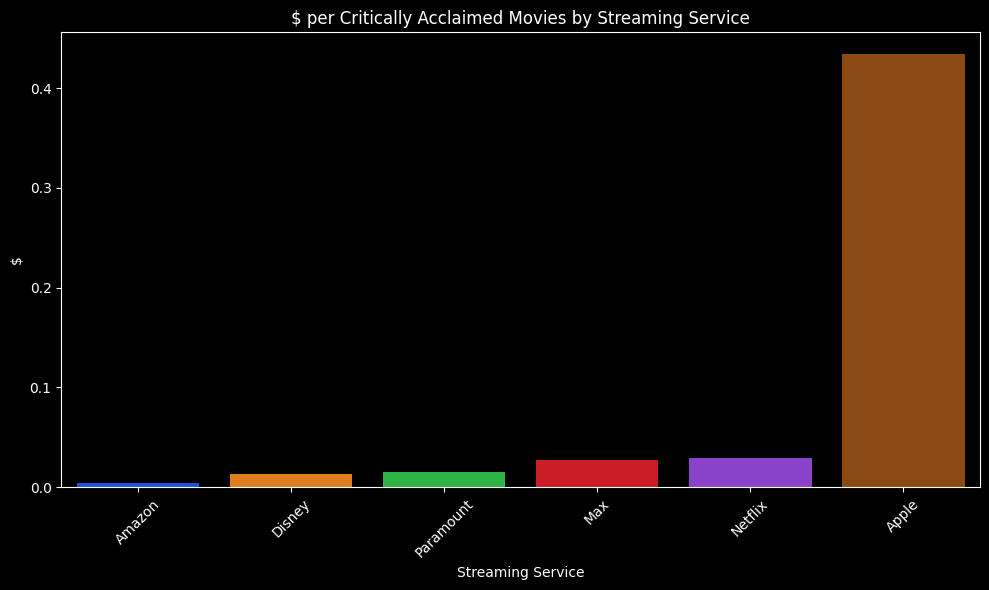

In [218]:
# Prepare the data for visualization
platforms, price = zip(*sorted_dict.items())

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=platforms, y=price, palette='bright', hue=platforms, legend=False)
plt.title('$ per Critically Acclaimed Movies by Streaming Service')
plt.ylabel('$')
plt.xlabel('Streaming Service')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

If you have FOMO and love a deal, then `Netflix` is your best choice for a streaming platform at **$0.17/movie**!

#### Kid Friendly

**Hypothesis**: Which streaming platform has more kid friendly movies/shows?
  - **Prediction**: *Disney+*

We'll count all the `age_rating = [G, PG]` values and then plot them for each platform.

In [161]:
# Define kid-friendly age certifications
kid_friendly_ratings = ['G', 'PG']

# Filter the DataFrame for kid-friendly movies
kid_friendly_df = merged_df[merged_df['age_certification'].isin(kid_friendly_ratings)]

# Count the number of kid-friendly movies on each platform
kid_friendly_counts = {
    'Amazon': kid_friendly_df['on_amazon'].sum(),
    'Apple': kid_friendly_df['on_apple'].sum(),
    'Disney': kid_friendly_df['on_disney'].sum(),
    'Max': kid_friendly_df['on_hbo'].sum(),
    'Netflix': kid_friendly_df['on_netflix'].sum(),
    'Paramount': kid_friendly_df['on_paramount'].sum(),
}

# Sort the kid-friendly counts dictionary by values and reverse to get from most to least
sorted_kid_friendly_counts = dict(sorted(kid_friendly_counts.items(), key=lambda item: item[1], reverse=True))

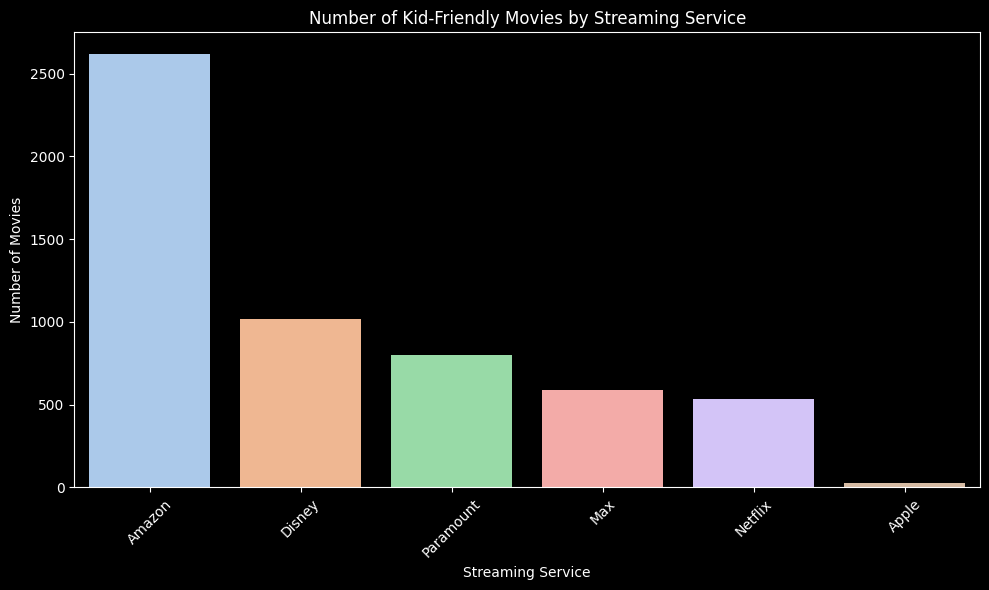

In [162]:
# Prepare the data for visualization
platforms, counts = zip(*sorted_kid_friendly_counts.items())

# Plotting with a color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=platforms, y=counts, palette='pastel', hue=platforms, legend=False)
plt.title('Number of Kid-Friendly Movies by Streaming Service')
plt.ylabel('Number of Movies')
plt.xlabel('Streaming Service')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [163]:
# Calculate dollars per kid-friendly movie
dollars_per_kid = {
    platform: (np.round(prices[platform] / kid_friendly_counts[platform], 4)) for platform in prices.keys() if kid_friendly_counts[platform] 
}

# Sort dictionary by values in ascending order
sorted_dict = dict(sorted(dollars_per_kid.items(), key=lambda item: item[1]))
print(sorted_dict)

{'Amazon': 0.0046, 'Disney': 0.0137, 'Paramount': 0.015, 'Max': 0.0273, 'Netflix': 0.0289, 'Apple': 0.4343}


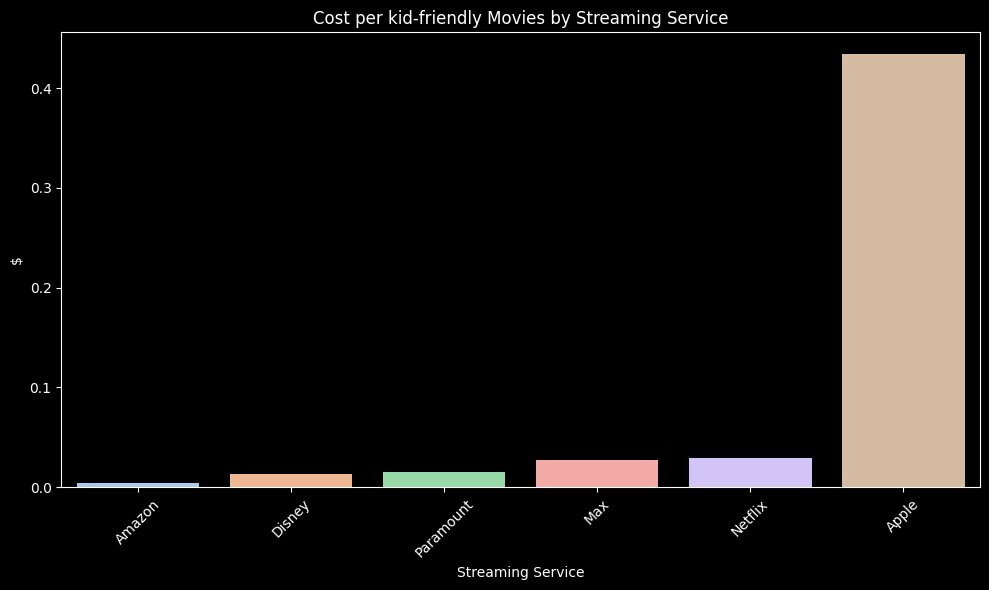

In [220]:
# Prepare the data for visualization
platforms, price = zip(*sorted_dict.items())

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=platforms, y=price, palette='pastel', hue=platforms, legend=False)
plt.title('Cost per kid-friendly Movies by Streaming Service')
plt.ylabel('$')
plt.xlabel('Streaming Service')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

If you are a parent or gaurdian and prioritze kids movies, then **Amazon** and **Disney** are the are the best values, at **$0.0141/movie** and **$0.0183/movie** respectfully.

#### Diversity

- **Hypothesis**: Which streaming platform has more diversity?
  - **Prediction**: *Amazon*

We will define diversity as the proportions of `genre` and `age_ranking` values for a platform. We'll weigh the contributions to diversity as **70%** `genre` and **30%** `age_ranking`. 

With this in mind, we will define a function using the `Shannon Diversity Index`, which is popular diversity index defined as the measure of the proportional abundances of types.

In [165]:
def shannon_diversity_index(counts: list) -> float:
    """Calculate the Shannon Diversity Index for a list of counts."""
    total = sum(counts)
    proportions = [count / total for count in counts]
    return -sum(p * np.log(p) for p in proportions if p > 0)

Now, we can calculate the shannon index for each paltform with respect to `genre` and `age_rating`. 

In [166]:
# We'll store the results in a dictionary
diversity_scores = {}

streaming_services = ['on_amazon', 'on_apple', 'on_disney', 'on_hbo', 'on_netflix', 'on_paramount']

# Calculate the Shannon Diversity Index for genres and age ratings for each streaming service
for service in streaming_services:
    service_data = merged_df[merged_df[service] == 1]
    
    # Flatten the list of genres for each movie into a single list and then get the counts
    genre_counts = service_data[unique_genres].sum()
    genre_sdi = shannon_diversity_index(genre_counts)
    
    # Get the counts of age certifications and calculate the SDI
    age_rating_counts = service_data['age_certification'].value_counts()
    age_rating_sdi = shannon_diversity_index(age_rating_counts)
    
    # Combine the SDI scores for an overall diversity score
    overall_sdi = (.7*genre_sdi + .3*age_rating_sdi)
    diversity_scores[service] = {
        'Genre Diversity': genre_sdi,
        'Age Rating Diversity': age_rating_sdi,
        'Overall Diversity': overall_sdi
    }

Let's plot these indexes:

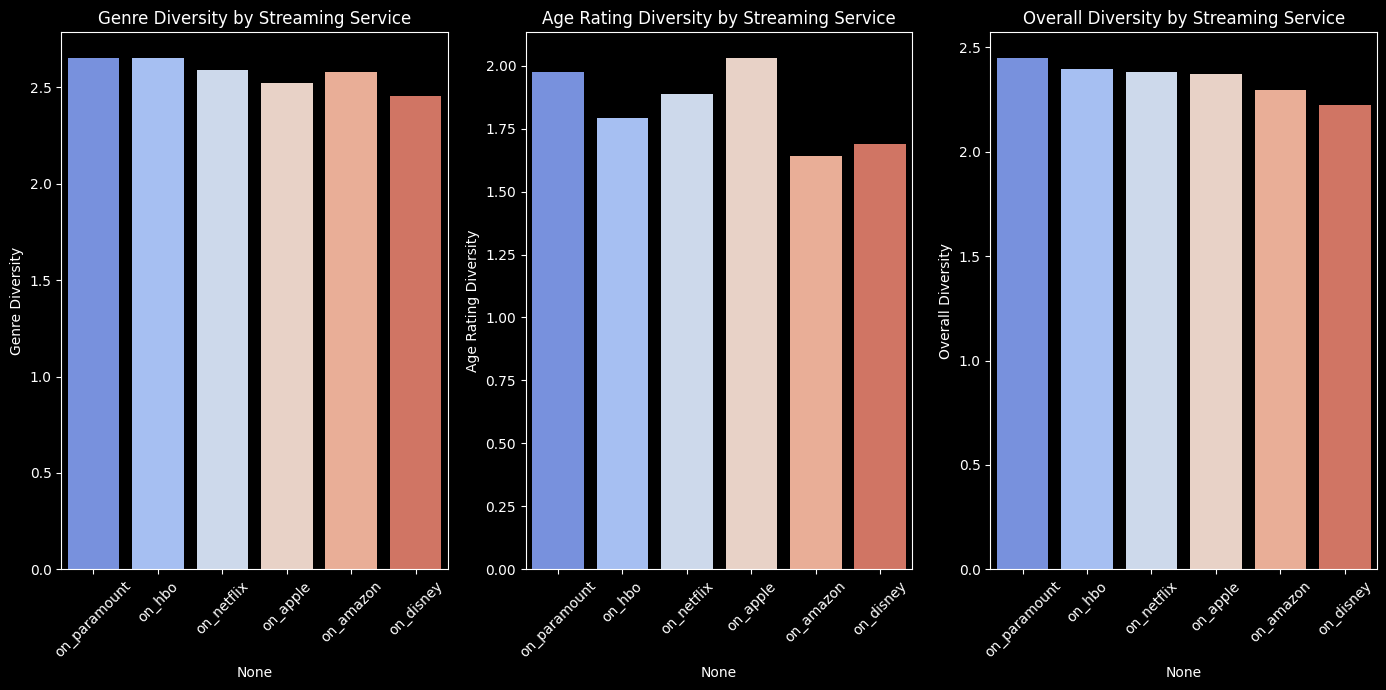

In [167]:
# Convert the dictionary to a DataFrame for easy plotting
diversity_df = pd.DataFrame(diversity_scores).T.sort_values(by='Overall Diversity', ascending=False)

# Plotting
plt.figure(figsize=(14, 7))

# Genre Diversity
plt.subplot(1, 3, 1)
sns.barplot(x=diversity_df.index, y='Genre Diversity', data=diversity_df, palette='coolwarm', hue=diversity_df.index, legend=False)
plt.title('Genre Diversity by Streaming Service')
plt.xticks(rotation=45)

# Age Rating Diversity
plt.subplot(1, 3, 2)
sns.barplot(x=diversity_df.index, y='Age Rating Diversity', data=diversity_df, palette='coolwarm', hue=diversity_df.index, legend=False)
plt.title('Age Rating Diversity by Streaming Service')
plt.xticks(rotation=45)

# Overall Diversity
plt.subplot(1, 3, 3)
sns.barplot(x=diversity_df.index, y='Overall Diversity', data=diversity_df, palette='coolwarm', hue=diversity_df.index, legend=False)
plt.title('Overall Diversity by Streaming Service')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


`Paramount` has the highest `genre` diversity and the 2nd highest `age_rating` diversity. This solidifies it as the most diverse streaming service, by a very slight margin.

The overall diversity metrics are so closely distributed, I doubt anyone can make any meaningful decisions about which platform to choose based on this metric.

The good news is: They all have great diversity! (which makes sense from a marketing perspective.)

### Model

#### Feature Engineering

To start, we'll need to encode our categorical data with numerical labels, normalize our numerical data, and make them arrays so they can be fed into our `KNN` model.

In [168]:
# Add streaming platform data to the feature matrix
streaming_columns = ['on_amazon', 'on_apple', 'on_disney', 'on_hbo', 'on_netflix', 'on_paramount']
streaming_data = merged_df[streaming_columns].values

# Encoder for 'type' and 'age_certification'
onehot_encoder = OneHotEncoder()
type_encoded = onehot_encoder.fit_transform(merged_df[['type']]).toarray()
age_certification_encoded = onehot_encoder.fit_transform(merged_df[['age_certification']]).toarray()

# Normalize the imdb_score/tmdb_popularity to have the same scale as genres_encoded
imdb_scores = merged_df['imdb_score'] / merged_df['imdb_score'].max()
tmdb_popularity_scaled = merged_df['tmdb_popularity'] / merged_df['tmdb_popularity'].max()
imdb_scores_reshaped = imdb_scores.values.reshape(-1, 1)
tmdb_popularity_reshaped = tmdb_popularity_scaled.values.reshape(-1, 1)

##### K-means

We use `Kmeans` to feature engineer in hopes of capturing underlying patterns or structures within `genre`. For example:
- Create clusters on similar `genre` values. 
- Reduce our high-dimensional dataframe of genre binaries into a smaller set of features representing cluster relationships.
- Reduce noise.
- Increase the similarities using these clusters to, hopefully, improve the similarity metric of our recommendations from the `KNN` model.

We will try to optimize the `k` parameter by creating an **elbow plot** of the **inertias** at each `k`. **Inertia** measures the intraconnectedness of the clusters.

In [169]:
# Range of k values to try
k_values = range(5, 200, 5)

# List to store each k value's inertia
inertias = []

# train model for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(merged_df[unique_genres])
    inertias.append(kmeans.inertia_)

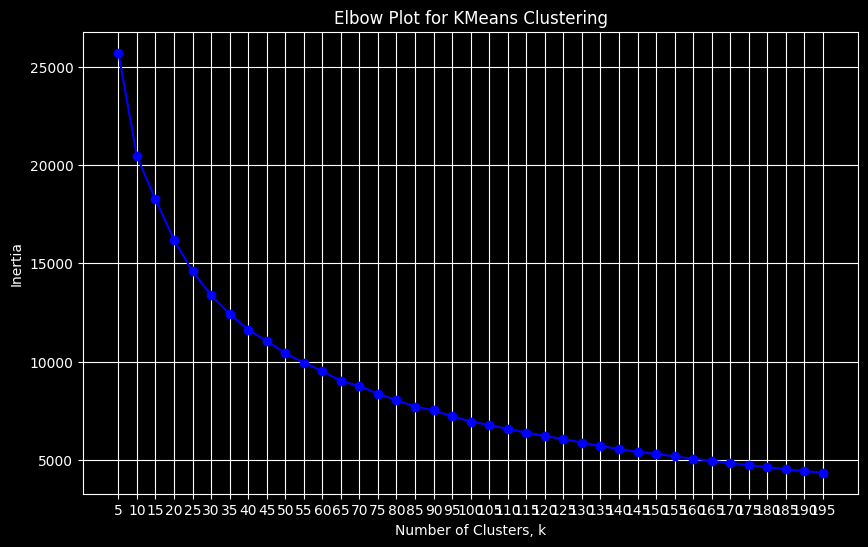

In [170]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Plot for KMeans Clustering')
plt.xticks(k_values)
plt.grid(True)
plt.show()

> The elbow plot resembles $f(x) = 1/x$​ without a distinct elbow. This suggests that the benefits of adding more clusters decrease slowly as the number of clusters increases. This situation can make it challenging to choose the optimal number of clusters based solely on the elbow plot.

Since there is no visible elbow, I chose a point that looked like there were obvious diminished returns for any `k` above it, `k = 55`.

In [223]:
n_clusters = 55 # Optimal k
kmeans = KMeans(n_clusters=n_clusters)
genres_cluster_labels = kmeans.fit_predict(merged_df[unique_genres]).reshape(-1, 1)

##### PCA

We use `PCA` for feature engineering so that we emphasize variation and bring out strong patterns in a dataset. It's also often used to:
- Reduce dimensionality of our data
- Capture the variance of the data that might correspond to latent features.

In [172]:
pca = PCA(n_components=0.95)  # retain 95% of variance
genres_pca = pca.fit_transform(merged_df[unique_genres])
print(pca.explained_variance_ratio_)

[0.17399535 0.14656639 0.12128527 0.08106872 0.06459037 0.05988484
 0.05168595 0.04447658 0.03653068 0.03474959 0.02961799 0.02788133
 0.02650059 0.02423983 0.02290889 0.0145069 ]


The first few components capture a significant portion of the variance, which suggests that the genre data is quite spread out. The gradual decline in the variance indicates no components dominate.

Since no individual component explains a dominant share of the variance, I think it's good to retain most of the components.

#### Training

For training the `KNN` model, I spent many hours adjusting the weights and cycled through many different combinations of each feature.

In [173]:
# Feature training weights
genre_weight = 3
imdb_weight = 2
type_weight = 1
age_weight = 2
tmdb_weight = 1
pca_weight = 1
cluster_weight = 2


# Combine all features into one feature matrix
X = np.hstack((
    merged_df[unique_genres] * genre_weight, 
    imdb_scores_reshaped * imdb_weight, 
    type_encoded * type_weight,
    age_certification_encoded * age_weight,
    #genres_pca * pca_weight,
    genres_cluster_labels * cluster_weight,
    tmdb_popularity_reshaped * tmdb_weight,
))

# Use NearestNeighbors for finding the nearest movies
knn = NearestNeighbors(n_neighbors=30, algorithm='auto', metric='euclidean')
knn.fit(X)

NearestNeighbors(metric='euclidean', n_neighbors=30)

To check how our `KNN` model did, we can look at the nearest neighbors for an arbitrary index, let's say index 0. We will print out indexes in order of closest to farthest in the neighborhood created by the model.

In [222]:
# Check neighbors for a specific item, index 0
distances, indices = knn.kneighbors([X[0]][:10])

# Display the nearest neighbors for the first item
print("Nearest Neighbors for the first item:")
for idx, dist in zip(indices[0], distances[0]):
    print(f"Index: {idx}, Distance: {dist}")

Nearest Neighbors for the first item:
Index: 0, Distance: 0.0
Index: 5715, Distance: 0.020888477395967744
Index: 7499, Distance: 0.0608503162733239
Index: 11327, Distance: 0.4040688775923941
Index: 9235, Distance: 0.42425551721771426
Index: 12026, Distance: 2.8289845143344197
Index: 12670, Distance: 2.8330407512672258
Index: 3047, Distance: 2.8335916653695223
Index: 12081, Distance: 2.8356351408719878
Index: 4661, Distance: 2.846844803262946
Index: 2541, Distance: 2.84701830505666
Index: 13159, Distance: 2.8492018803114694
Index: 2488, Distance: 2.8492030085199733
Index: 6004, Distance: 2.849203364190994
Index: 10313, Distance: 2.849214627806801
Index: 11719, Distance: 2.8517080459894197
Index: 4997, Distance: 2.8517112572663414
Index: 15826, Distance: 2.8571399852891957
Index: 2534, Distance: 2.857140018893967
Index: 10035, Distance: 2.8671066759829564
Index: 10189, Distance: 2.8731651868487216
Index: 2640, Distance: 2.9059432718823333
Index: 7726, Distance: 2.9106412119157103
Index: 

That is difficult to understand, so lets print the features for the indexes the `KNN` model calculated to be closest to `Index 0`.

In [179]:
# Print details of the nearest neighbors
for i in indices[0][:7]:
    print(merged_df.iloc[i][['title', 'genres', 'imdb_score', 'tmdb_popularity']], "\n")


title                             Star Wars
genres             [scifi, action, fantasy]
imdb_score                              8.6
tmdb_popularity                      77.321
Name: 0, dtype: object 

title               The Empire Strikes Back
genres             [scifi, action, fantasy]
imdb_score                              8.7
tmdb_popularity                      27.802
Name: 5716, dtype: object 

title                    Return of the Jedi
genres             [action, scifi, fantasy]
imdb_score                              8.3
tmdb_popularity                      26.537
Name: 7500, dtype: object 

title              Star Wars: Episode II - Attack of the Clones
genres                                 [scifi, fantasy, action]
imdb_score                                                  6.6
tmdb_popularity                                          32.596
Name: 11328, dtype: object 

title              Star Wars: Episode I - The Phantom Menace
genres                              [scifi, a

**This looks like the model did an amazing job! We... did an even better job, pat your back!**

But I would love to go a littler further and make a little app out of this!
To do this, I'll write a function that makes a recommendation for a specific move title.

#### Recommendations

After many, many hours trying to make the ***perfect*** recommendation function, I noticed that for some (maybe most) movies the genres of the recommended movies were completely off.

This makes sense though, I didn't think our dataset had enough nuanced data to create a perfect recommendation system for every movie. Here were a couple bug's I found:
- **"2001: A Space Odyssey"**: Only returned `comedy` specials.
- **"Prometheus"**: Only returned `western` movies.
- **"The Handmaiden"**: Only returned `musical`, `documentary` movies.

To make a better recommendation system, I filtered the recommended movies by the intersection of `genre` values. Working on the assumption that similar movies should have similar genres. This would return the closest movies with similar genres, thus filtering out the mismatched movies 

For this movie recommendation function, we will do the following:
1. Use `regex` to take an input and generalize the string to a pattern.
2. Use this pattern and find all movie titles that contain it.
3. Define a minimum `genre` count to have in common with the input movie.
4. Set the input movie as index 0, like we did above.
5. Filter the closest indexes (movies) with the minimum `genre` count constraint.
6. Filter these movies by the streaming platforms they are on. 
6. Print top 5 recommendations in a readable way.

In [211]:
def make_recommendation(movie_title, knn_model, data, features, num_neighbors, available_services):
    # Save title to print later
    print_movie = movie_title
    movie_title = movie_title.strip().lower()

    # Create regex pattern and find movie
    pattern = re.compile(re.escape(movie_title), re.IGNORECASE)
    matches = data[data['title'].str.contains(pattern)]

    # Check if no movie was found
    if matches.empty:
        print(f"No matching movie found for '{movie_title}'. Please check the title and try again.")
        return
    
    # Set movie to Index 0
    index = matches.index[0]
    
    # Make set with all genres 
    query_genres = set(matches.at[index, 'genres'])
    min_genre_match = len(query_genres) - 1 # Create constraint

    distances, indices = knn_model.kneighbors([features[index]], n_neighbors=len(data))
    recommendations = []

    # Cycle through movie recs per knn model
    for idx, dist in zip(indices[0], distances[0]):
        if idx == index:
            continue  # Skip the input movie itself
        
        # Save relevant movie rec data
        movie_data = data.iloc[idx]
        movie_genres = set(movie_data['genres'])
        common_genres = query_genres.intersection(movie_genres) # Intersection of genres

        # Add all movies that exceed genre constraint AND are on the platforms specified to recommendations list
        if len(common_genres) >= min_genre_match:
            movie_services = [service for service in available_services if movie_data[service] == 1]
            if movie_services:
                recommendations.append({
                    'title': movie_data['title'],
                    'year': movie_data['release_year'],
                    'genres': movie_genres,
                    'services': ', '.join([s.replace('on_', '').capitalize() for s in movie_services]),
                    'distance': dist  # Keep the distance for sorting later
                })

        # Set maximum distance for movie recs
        if len(recommendations) >= num_neighbors * 10:  # Get more than needed to filter by service availability
            break
    
    # Sort by distance, then by the number of matching genres
    recommendations.sort(key=lambda x: (x['distance'], -len(x['genres'])))

    # Select the top recommendations that are available on the specified streaming services
    final_recommendations = [rec for rec in recommendations if rec['services']][:num_neighbors]

    # Print recommendations
    if final_recommendations:
        print(f"\n--- Recommendations for '{print_movie}' ---\n")
        for rec in final_recommendations:
            print(f"Title: {rec['title']} ({rec['year']})\nGenres: {list(rec['genres'])[:min(3,len(rec['genres']))]}\nAvailable on: {rec['services']}\n")
    else:
        print("Unable to find enough similar movies available on your streaming services with enough genre overlap.")


Great! Let's test to see if this works on some of the bugged movies we outlined earlier. Feel free to comment out any streaming services and see what recommendation you receive as a result.

In [212]:
# Test
available_services = ['on_amazon', 
                      'on_apple', 
                      'on_disney', 
                      'on_hbo', 
                      'on_netflix', 
                      'on_paramount']

make_recommendation('The Matrix', knn, merged_df, X, 5, available_services)
make_recommendation('2001: A Space Odyssey', knn, merged_df, X, 5, available_services)
make_recommendation('The Handmaiden', knn, merged_df, X, 5, available_services)


--- Recommendations for 'The Matrix' ---

Title: Prometheus (2012)
Genres: ['scifi', 'action']
Available on: Amazon

Title: The Matrix Resurrections (2021)
Genres: ['scifi', 'action']
Available on: Hbo

Title: Occupation: Rainfall (2020)
Genres: ['scifi', 'action']
Available on: Netflix

Title: Skylines (2020)
Genres: ['scifi', 'action']
Available on: Netflix

Title: Gen-Y Cops (2000)
Genres: ['scifi', 'action']
Available on: Amazon


--- Recommendations for '2001: A Space Odyssey' ---

Title: Doom Patrol (2019)
Genres: ['scifi', 'action', 'comedy']
Available on: Hbo

Title: The Adam Project (2022)
Genres: ['drama', 'action', 'scifi']
Available on: Netflix

Title: ReBoot: The Guardian Code (2018)
Genres: ['drama', 'action', 'scifi']
Available on: Netflix

Title: Star Trek: Picard (2020)
Genres: ['scifi', 'action', 'drama']
Available on: Paramount

Title: Twice Upon a Time (2019)
Genres: ['drama', 'comedy', 'romance']
Available on: Netflix


--- Recommendations for 'The Handmaiden' ---

Awesome!! Now let's create a function that loops over this function and asks for inputs from the user to specify the parameters!

In [225]:
def user_input_recommendation():
    streaming_services = ['on_amazon', 'on_apple', 'on_disney', 'on_hbo', 'on_netflix', 'on_paramount']
    
    # Prompt user for their streaming services availability
    services_input = {}
    for service in streaming_services:
        user_input = input(f"Do you have access to {service}? (1 for yes, 0 for no, q to quit): ")
        while user_input not in ['0', '1']:
            if user_input == 'q':
                print("Exiting program.")
                return
            print("Invalid input. Please enter 1 for yes, 0 for no, or q to quit.")
            user_input = input(f"Do you have access to {service}? (1 for yes, 0 for no, q to quit): ")
        services_input[service] = int(user_input)
    

    # Save available streaming services
    available_services = [service for service in streaming_services if services_input[service] == 1]
    
    # Run program until told not to
    while True:
        # Save input movie
        movie_title = input("Enter a movie title (q to quit): ")
        if movie_title.lower() == 'q':
            print("Exiting program.")
            break
        
        # Normalize movie title input and search for regex match in the DataFrame
        movie_title_regex = re.compile(re.escape(movie_title), re.IGNORECASE)
        matched_movies = merged_df[merged_df['title'].apply(lambda x: bool(movie_title_regex.search(x)))]

        # Check for no match
        if matched_movies.empty:
            print(f"No movies found matching '{movie_title}'. Please try a different title.")

        else:
            # Display up to the top 5 matches for the user to choose from
            print("Multiple matches found matching '{movie_title}'. Please select the correct movie (q to quit):", flush=True)

            choices = [""] * 5
            corr_choice = False
            # Ask for input until correct input given
            while not corr_choice:
                # Print matching movies
                for i, title in enumerate(matched_movies['title'].head(5), 1):
                    print(f"{i}: {title}")
                    choices[i-1] = title

                choice = input("Enter the number of the correct movie (or 0 to re-enter title, q to quit): ")
                
                if choice.lower() == 'q':
                    print("Exiting program.")
                    return
                # Find recommendation based on user choice
                elif choice.isdigit() and 0 <= int(choice) <= len(matched_movies.head(5)):
                    corr_choice = True
                    if int(choice) == 0:
                        continue
                    selected_movie = choices[int(choice)-1]
                    make_recommendation(selected_movie, knn, merged_df, X, 5, available_services)
                    print("-"*100 + "\n", flush=True)
                # Check for invalid choice
                else:
                    print("Invalid selection. Please try again.\n")

Amazing! We built a barebones movie/show recommendation app! Try it out!

In [226]:
# Call our recommendation app
def __main__() -> None:
    user_input_recommendation()

if __name__ == "__main__":
    __main__()

Exiting program.


## Overview

A bulleted overview of the techniques used:
- **Data Merging**: Combined datasets from different streaming platforms using `outer joins`.
- **Data Cleaning**: Standardized and cleaned the data to ensure consistency and accuracy for analysis.
- **Imputation Techniques**:
  - **Basic Imputes**: Filled in missing values with basic imputes such as mean and median.
  - **Regression Imputes**: Used `regression models` to predict and impute missing numerical values, such as `imdb_score` and `tmdb_popularity` scores.
  - **Logarithmic Impute**:  Used `logarithmic models` to predict and impute missing categorical values, such as `age_ranking`. 
    - **Transformed Data**: For skewed distributions, applied `logarithmic transformations` to stabilize variance and improve imputation accuracy.
- **Analytical Hypotheses Testing**:
  - Evaluated the distribution of critically acclaimed movies across platforms.
  - Assessed the popularity metrics across platforms.
  - Investigated kid-friendly content across platforms.
  - Analyzed diversity in genres and age ratings across different platforms.
- **Feature Engineering for Model Input**:
  - **K-Means Clustering**: Grouped similar genres to capture their relationships, reducing the feature space complexity.
  - **PCA (Principal Component Analysis)**: Reduced the dimensionality of the genre features, enhancing model performance and interpretability.
- **Model Training and Recommendations**:
  - Developed a `KNN` (K-Nearest Neighbors) model to find similar movies based on the engineered features.
  - Weighted features differently to adjust their influence on the model's distance calculations and recommendations.
  - Developed `regex` patterns to match specified movie `title`. 


***Thank you, and kind wishes! :)***